In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical

In [3]:
import keras as keras

In [4]:
DF=pd.read_csv("../../Data/1999_2021/aggragate_daily_data_2000to2020.csv",index_col=0)
DF_rain=pd.read_csv("../../Data/historic_weather.csv")

In [5]:
#DF.head(15)

In [6]:
DF.date=pd.to_datetime(DF.date)
DF_rain.date=pd.to_datetime(DF_rain.date)
DF_rain.dtypes

date        datetime64[ns]
hour               float64
station             object
rain_mm            float64
temp_max           float64
temp_min           float64
dtype: object

In [7]:
#Create some lags
def sum2(x):
    if all(x.isna()):
        return np.nan
    else:
        return np.sum(x)


KK=DF_rain.groupby(['date','station']).agg(rain_mm=('rain_mm',sum2)).reset_index().sort_values(['station','date'])    

In [8]:
Rain_pivot=KK.pivot(index='date', columns='station', values='rain_mm')
Rain_pivot.columns.name=None
Rain_pivot

,A705 BAURU,A711 SAO CARLOS,A737 IBITINGA,A741 BARRA BONITA
date,,,,
2007-01-01,40.6,NaN,NaN,NaN
2007-01-02,48.8,NaN,NaN,NaN
2007-01-03,18.2,NaN,NaN,NaN
2007-01-04,1.4,NaN,NaN,NaN
2007-01-05,29.4,NaN,NaN,NaN
...,...,...,...,...
2020-12-27,51.0,12.8,0.0,0.0
2020-12-28,29.8,29.4,0.0,0.0
2020-12-29,62.4,12.6,0.0,0.0


In [9]:
DF=DF.reset_index()

In [10]:
DF['year']=0
DF['month']=0
DF['month_day']=0
DF['year_day']=0
DF['weekday']=0

for ind in DF.index:
    date=DF.date[ind]
    date_st=date.timetuple()
    DF.loc[ind,'year']=date_st.tm_year
    DF.loc[ind,'month']=date_st.tm_mon
    DF.loc[ind,'month_day']=date_st.tm_mday
    DF.loc[ind,'year_day']=date_st.tm_yday
    DF.loc[ind,'weekday']=date_st.tm_wday
DF

,index,date,energy_charge,effluent_flow,influent_flow,volume_used,poured_flow,water_level,energy_generated,energy_stored,maximum_demand,year,month,month_day,year_day,weekday
0,1,2000-01-01,457.103900,226.12,185.42,20.84,0.0,443.08,0.721700,20346.61650,25253.000,2000,1,1,1,5
1,2,2000-01-02,465.552600,255.12,459.28,21.53,0.0,443.06,0.823800,20944.16550,26388.000,2000,1,2,2,6
2,3,2000-01-03,553.481900,263.12,885.74,23.63,0.0,443.16,0.833400,21915.00000,29633.000,2000,1,3,3,0
3,4,2000-01-04,581.477800,373.12,1011.04,25.78,0.0,443.46,1.215900,23301.48900,30230.000,2000,1,4,4,1
4,5,2000-01-05,595.390500,483.12,916.95,27.24,0.0,443.76,1.556100,24564.52350,30661.000,2000,1,5,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7298,7299,2019-12-27,912.189387,323.00,323.00,53.89,25.0,447.17,1.163433,30146.37673,43231.117,2019,12,27,361,4
7299,7300,2019-12-28,880.473677,375.00,209.72,53.34,25.0,447.11,1.362688,30230.79799,43006.734,2019,12,28,362,5
7300,7301,2019-12-29,827.558858,299.00,216.71,53.06,25.0,447.08,1.058915,30351.00804,40620.258,2019,12,29,363,6
7301,7302,2019-12-30,893.432298,345.00,208.08,52.60,25.0,447.03,1.256731,30155.61356,41780.441,2019,12,30,364,0


In [11]:
DF=DF.fillna(0)

In [12]:
DF0=DF.copy()

# Time Series

In [56]:
date_train='2016-01-01'
date_validate='2018-01-01'

DF=DF0[['energy_generated','water_level','maximum_demand','month','date','energy_stored']]
DF=DF0[['energy_generated','date','effluent_flow']]


y_var='energy_generated'
X_train=np.array(DF.drop(['date',y_var],axis=1)[DF.date<date_train])
y_train=np.array(DF[y_var][DF.date<date_train])

X_valid=np.array(DF.drop(['date',y_var],axis=1)[(date_train<=DF.date) & (DF.date<date_validate)])
y_valid=np.array(DF[y_var][(date_train<=DF.date) & (DF.date<date_validate)])

X_test=np.array(DF.drop(['date',y_var],axis=1)[DF.date>=date_validate])
y_test=np.array(DF[y_var][DF.date>=date_validate])

In [57]:
#X_train = np.reshape(X_train, (len(X_train), X_train.shape[1],1))
#X_valid = np.reshape(X_valid, (len(X_valid), X_valid.shape[1],1))
X_train.shape

(5842, 1)

In [72]:
model = models.Sequential()
model.add(layers.LSTM(10, activation='tanh',input_shape=[None,1],return_sequences=True))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, None, 10)          480       
Total params: 480
Trainable params: 480
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer='rmsprop',loss='mse', metrics=['mse'])
history = model.fit(X_train,y_train,epochs = 500)

Epoch 1/500
183/183 [==============================] - 0s 705us/step - loss: 19589.0703 - mse: 19589.0703
Epoch 2/500
183/183 [==============================] - 0s 695us/step - loss: 1119.3018 - mse: 1119.3018
Epoch 3/500
183/183 [==============================] - 0s 662us/step - loss: 0.6394 - mse: 0.6394
Epoch 4/500
183/183 [==============================] - 0s 632us/step - loss: 0.4376 - mse: 0.4376
Epoch 5/500
183/183 [==============================] - 0s 659us/step - loss: 0.3673 - mse: 0.3673
Epoch 6/500
183/183 [==============================] - 0s 640us/step - loss: 0.3015 - mse: 0.3015
Epoch 7/500
183/183 [==============================] - 0s 758us/step - loss: 0.2772 - mse: 0.2772
Epoch 8/500
183/183 [==============================] - 0s 677us/step - loss: 0.2509 - mse: 0.2509
Epoch 9/500
183/183 [==============================] - 0s 638us/step - loss: 0.2308 - mse: 0.2308
Epoch 10/500
183/183 [==============================] - 0s 645us/step - loss: 0.2120 - mse: 0.2120
Epoch

183/183 [==============================] - 0s 578us/step - loss: 0.0672 - mse: 0.0672
Epoch 84/500
183/183 [==============================] - 0s 745us/step - loss: 0.0635 - mse: 0.0635
Epoch 85/500
183/183 [==============================] - 0s 943us/step - loss: 0.0638 - mse: 0.0638
Epoch 86/500
183/183 [==============================] - 0s 922us/step - loss: 0.0635 - mse: 0.0635
Epoch 87/500
183/183 [==============================] - 0s 883us/step - loss: 0.0620 - mse: 0.0620
Epoch 88/500
183/183 [==============================] - 0s 754us/step - loss: 0.0586 - mse: 0.0586
Epoch 89/500
183/183 [==============================] - 0s 650us/step - loss: 0.0622 - mse: 0.0622
Epoch 90/500
183/183 [==============================] - 0s 736us/step - loss: 0.0587 - mse: 0.0587
Epoch 91/500
183/183 [==============================] - 0s 812us/step - loss: 0.0620 - mse: 0.0620
Epoch 92/500
183/183 [==============================] - 0s 796us/step - loss: 0.0602 - mse: 0.0602
Epoch 93/500
183/183 [=

183/183 [==============================] - 0s 796us/step - loss: 0.0466 - mse: 0.0466
Epoch 166/500
183/183 [==============================] - 0s 768us/step - loss: 0.0508 - mse: 0.0508
Epoch 167/500
183/183 [==============================] - 0s 637us/step - loss: 0.0476 - mse: 0.0476
Epoch 168/500
183/183 [==============================] - 0s 817us/step - loss: 0.0516 - mse: 0.0516
Epoch 169/500
183/183 [==============================] - 0s 741us/step - loss: 0.0468 - mse: 0.0468
Epoch 170/500
183/183 [==============================] - 0s 774us/step - loss: 0.0484 - mse: 0.0484
Epoch 171/500
183/183 [==============================] - 0s 752us/step - loss: 0.0499 - mse: 0.0499
Epoch 172/500
183/183 [==============================] - 0s 768us/step - loss: 0.0509 - mse: 0.0509
Epoch 173/500
183/183 [==============================] - 0s 711us/step - loss: 0.0477 - mse: 0.0477
Epoch 174/500
183/183 [==============================] - 0s 729us/step - loss: 0.0507 - mse: 0.0507
Epoch 175/500


183/183 [==============================] - 0s 1ms/step - loss: 0.0440 - mse: 0.0440
Epoch 248/500
183/183 [==============================] - 0s 807us/step - loss: 0.0422 - mse: 0.0422
Epoch 249/500
183/183 [==============================] - 0s 807us/step - loss: 0.0431 - mse: 0.0431
Epoch 250/500
183/183 [==============================] - 0s 785us/step - loss: 0.0439 - mse: 0.0439
Epoch 251/500
183/183 [==============================] - 0s 790us/step - loss: 0.0448 - mse: 0.0448
Epoch 252/500
183/183 [==============================] - 0s 850us/step - loss: 0.0425 - mse: 0.0425
Epoch 253/500
183/183 [==============================] - 0s 785us/step - loss: 0.0471 - mse: 0.0471
Epoch 254/500
183/183 [==============================] - 0s 839us/step - loss: 0.0453 - mse: 0.0453
Epoch 255/500
183/183 [==============================] - 0s 817us/step - loss: 0.0429 - mse: 0.0429
Epoch 256/500
183/183 [==============================] - 0s 790us/step - loss: 0.0471 - mse: 0.0471
Epoch 257/500
18

183/183 [==============================] - 0s 670us/step - loss: 0.0408 - mse: 0.0408
Epoch 329/500
183/183 [==============================] - 0s 616us/step - loss: 0.0406 - mse: 0.0406
Epoch 330/500
183/183 [==============================] - 0s 608us/step - loss: 0.0419 - mse: 0.0419
Epoch 331/500
183/183 [==============================] - 0s 605us/step - loss: 0.0427 - mse: 0.0427
Epoch 332/500
183/183 [==============================] - ETA: 0s - loss: 0.0416 - mse: 0.041 - 0s 598us/step - loss: 0.0415 - mse: 0.0415
Epoch 333/500
183/183 [==============================] - 0s 604us/step - loss: 0.0428 - mse: 0.0428
Epoch 334/500
183/183 [==============================] - 0s 604us/step - loss: 0.0422 - mse: 0.0422
Epoch 335/500
183/183 [==============================] - 0s 604us/step - loss: 0.0428 - mse: 0.0428
Epoch 336/500
183/183 [==============================] - 0s 586us/step - loss: 0.0405 - mse: 0.0405
Epoch 337/500
183/183 [==============================] - 0s 586us/step - los

183/183 [==============================] - 0s 695us/step - loss: 0.0411 - mse: 0.0411
Epoch 410/500
183/183 [==============================] - 0s 605us/step - loss: 0.0429 - mse: 0.0429
Epoch 411/500
183/183 [==============================] - 0s 598us/step - loss: 0.0400 - mse: 0.0400
Epoch 412/500
183/183 [==============================] - 0s 582us/step - loss: 0.0380 - mse: 0.0380
Epoch 413/500
183/183 [==============================] - 0s 610us/step - loss: 0.0412 - mse: 0.0412
Epoch 414/500
183/183 [==============================] - 0s 595us/step - loss: 0.0386 - mse: 0.0386
Epoch 415/500
183/183 [==============================] - 0s 593us/step - loss: 0.0399 - mse: 0.0399
Epoch 416/500
183/183 [==============================] - 0s 598us/step - loss: 0.0404 - mse: 0.0404
Epoch 417/500
183/183 [==============================] - 0s 610us/step - loss: 0.0400 - mse: 0.0400
Epoch 418/500
183/183 [==============================] - 0s 598us/step - loss: 0.0406 - mse: 0.0406
Epoch 419/500


183/183 [==============================] - 0s 625us/step - loss: 0.0384 - mse: 0.0384
Epoch 492/500
183/183 [==============================] - 0s 616us/step - loss: 0.0399 - mse: 0.0399
Epoch 493/500
183/183 [==============================] - 0s 594us/step - loss: 0.0408 - mse: 0.0408
Epoch 494/500
183/183 [==============================] - 0s 614us/step - loss: 0.0388 - mse: 0.0388
Epoch 495/500
183/183 [==============================] - 0s 632us/step - loss: 0.0396 - mse: 0.0396
Epoch 496/500
183/183 [==============================] - 0s 658us/step - loss: 0.0399 - mse: 0.0399
Epoch 497/500
183/183 [==============================] - 0s 619us/step - loss: 0.0391 - mse: 0.0391
Epoch 498/500
183/183 [==============================] - 0s 704us/step - loss: 0.0376 - mse: 0.0376
Epoch 499/500
183/183 [==============================] - 0s 627us/step - loss: 0.0399 - mse: 0.0399
Epoch 500/500
183/183 [==============================] - 0s 619us/step - loss: 0.0399 - mse: 0.0399


In [64]:
#Finally check
y_valid=np.reshape(y_valid,(len(y_valid),1))
y_pred=model.predict(X_valid)
np.mean((y_pred-y_valid)**2)

0.5264116733680353

(731, 1, 1)

ValueError: x and y can be no greater than 2-D, but have shapes (731,) and (731, 1, 1)

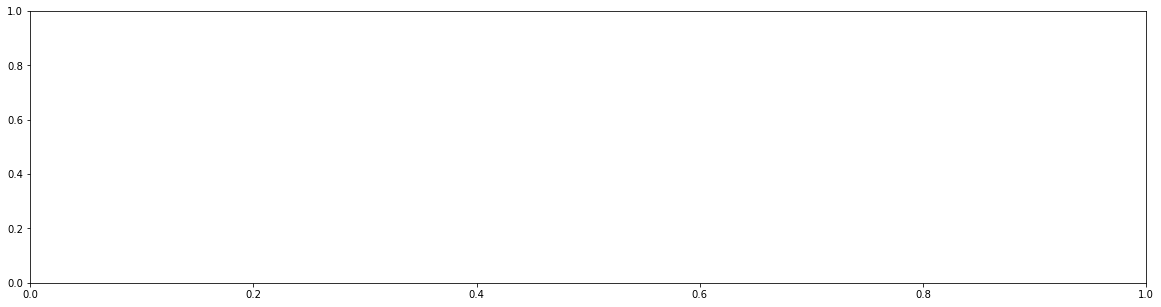

In [65]:
plt.figure(figsize=(20,5))
plt.plot(y_pred,color='blue')
plt.plot(y_valid,color='red',alpha=0.5)
plt.show()

## Trial 2

In [32]:
model = models.Sequential()
model.add(layers.LSTM(50, activation='tanh',input_shape=[X_train.shape[1],1]))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 10,921
Trainable params: 10,921
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='rmsprop',loss='mse', metrics=['mse'])
history = model.fit(X_train,y_train,epochs = 200,validation_data=(X_valid,y_valid))

Epoch 1/200
183/183 [==============================] - 1s 6ms/step - loss: 0.3283 - mse: 0.3283 - val_loss: 0.2683 - val_mse: 0.2683
Epoch 2/200
183/183 [==============================] - 1s 3ms/step - loss: 0.2749 - mse: 0.2749 - val_loss: 0.2842 - val_mse: 0.2842
Epoch 3/200
183/183 [==============================] - 1s 3ms/step - loss: 0.2710 - mse: 0.2710 - val_loss: 0.2386 - val_mse: 0.2386
Epoch 4/200
183/183 [==============================] - 0s 3ms/step - loss: 0.2730 - mse: 0.2730 - val_loss: 0.2386 - val_mse: 0.2386
Epoch 5/200
183/183 [==============================] - 1s 4ms/step - loss: 0.2670 - mse: 0.2670 - val_loss: 0.2691 - val_mse: 0.2691
Epoch 6/200
183/183 [==============================] - 1s 4ms/step - loss: 0.2673 - mse: 0.2673 - val_loss: 0.2438 - val_mse: 0.2438
Epoch 7/200
183/183 [==============================] - 1s 3ms/step - loss: 0.2654 - mse: 0.2654 - val_loss: 0.2401 - val_mse: 0.2401
Epoch 8/200
183/183 [==============================] - 1s 3ms/step - 

183/183 [==============================] - 1s 4ms/step - loss: 0.2532 - mse: 0.2532 - val_loss: 0.2440 - val_mse: 0.2440
Epoch 124/200
183/183 [==============================] - 1s 4ms/step - loss: 0.2534 - mse: 0.2534 - val_loss: 0.2451 - val_mse: 0.2451
Epoch 125/200
183/183 [==============================] - 1s 3ms/step - loss: 0.2542 - mse: 0.2542 - val_loss: 0.2368 - val_mse: 0.2368
Epoch 126/200
183/183 [==============================] - 1s 3ms/step - loss: 0.2544 - mse: 0.2544 - val_loss: 0.2648 - val_mse: 0.2648
Epoch 127/200
183/183 [==============================] - 1s 3ms/step - loss: 0.2531 - mse: 0.2531 - val_loss: 0.2553 - val_mse: 0.2553
Epoch 128/200
183/183 [==============================] - 1s 5ms/step - loss: 0.2530 - mse: 0.2530 - val_loss: 0.2565 - val_mse: 0.2565
Epoch 129/200
183/183 [==============================] - 1s 5ms/step - loss: 0.2532 - mse: 0.2532 - val_loss: 0.2627 - val_mse: 0.2627
Epoch 130/200
183/183 [==============================] - 1s 6ms/step 

In [25]:
#Finally check
y_valid=np.reshape(y_valid,(len(y_valid),1))
y_pred=model.predict(X_valid)
np.mean((y_pred-y_valid)**2)

2.077041998273348

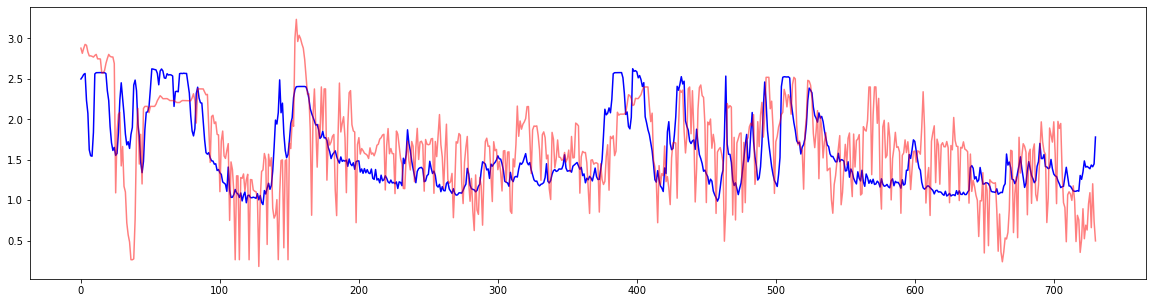

In [35]:
plt.figure(figsize=(20,5))
plt.plot(y_pred,color='blue')
plt.plot(y_valid,color='red',alpha=0.5)
plt.show()

# Trial 3

In [47]:
date_train='2016-01-01'
date_validate='2018-01-01'

DF=DF0[['energy_generated','maximum_demand','effluent_flow','date']]

y_var='energy_generated'
X_train=np.array(DF.drop(['date',y_var],axis=1)[DF.date<date_train])
y_train=np.array(DF[y_var][DF.date<date_train])

X_valid=np.array(DF.drop(['date',y_var],axis=1)[(date_train<=DF.date) & (DF.date<date_validate)])
y_valid=np.array(DF[y_var][(date_train<=DF.date) & (DF.date<date_validate)])

X_test=np.array(DF.drop(['date',y_var],axis=1)[DF.date>=date_validate])
y_test=np.array(DF[y_var][DF.date>=date_validate])

In [48]:
X_train = np.reshape(X_train, (len(X_train), X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (len(X_valid), X_train.shape[1], 1))

In [49]:
model = models.Sequential()
model.add(layers.LSTM(25, activation='tanh',input_shape=[X_train.shape[1],1]))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 25)                2700      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 26        
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='rmsprop',loss='mse', metrics=['mse'])
history = model.fit(X_train,y_train,epochs = 20,validation_data=(X_valid,y_valid))

Epoch 1/20
183/183 [==============================] - 1s 4ms/step - loss: 0.6039 - mse: 0.6039 - val_loss: 0.2092 - val_mse: 0.2092
Epoch 2/20
183/183 [==============================] - 0s 2ms/step - loss: 0.1411 - mse: 0.1411 - val_loss: 0.0662 - val_mse: 0.0662
Epoch 3/20
183/183 [==============================] - 0s 2ms/step - loss: 0.0679 - mse: 0.0679 - val_loss: 0.0476 - val_mse: 0.0476
Epoch 4/20
183/183 [==============================] - 0s 2ms/step - loss: 0.0566 - mse: 0.0566 - val_loss: 0.0537 - val_mse: 0.0537
Epoch 5/20
183/183 [==============================] - 0s 2ms/step - loss: 0.0558 - mse: 0.0558 - val_loss: 0.0580 - val_mse: 0.0580
Epoch 6/20
183/183 [==============================] - 0s 2ms/step - loss: 0.0538 - mse: 0.0538 - val_loss: 0.1046 - val_mse: 0.1046
Epoch 7/20
183/183 [==============================] - 0s 2ms/step - loss: 0.0518 - mse: 0.0518 - val_loss: 0.1001 - val_mse: 0.1001
Epoch 8/20
183/183 [==============================] - 0s 3ms/step - loss: 0.

In [51]:
#Finally check
y_valid=np.reshape(y_valid,(len(y_valid),1))
y_pred=model.predict(X_valid)
np.mean((y_pred-y_valid)**2)

0.08727489286331702

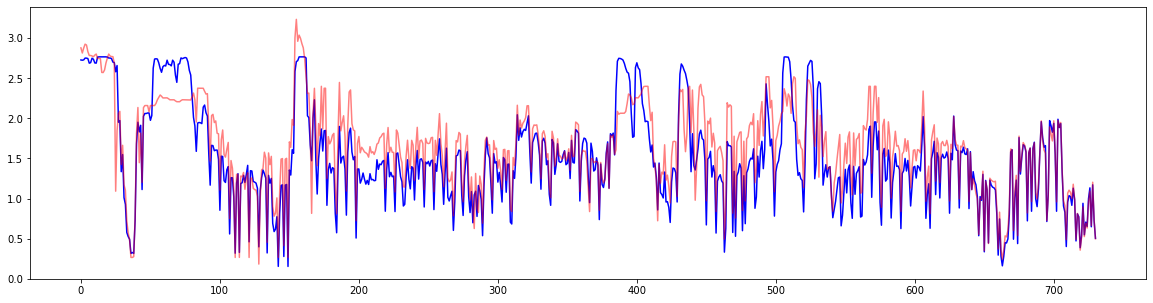

In [52]:
plt.figure(figsize=(20,5))
plt.plot(y_pred,color='blue')
plt.plot(y_valid,color='red',alpha=0.5)
plt.show()

# Trial 4

In [53]:
date_train='2016-01-01'
date_validate='2018-01-01'

DF=DF0[['energy_generated','effluent_flow','date']]

y_var='energy_generated'
X_train=np.array(DF.drop(['date',y_var],axis=1)[DF.date<date_train])
y_train=np.array(DF[y_var][DF.date<date_train])

X_valid=np.array(DF.drop(['date',y_var],axis=1)[(date_train<=DF.date) & (DF.date<date_validate)])
y_valid=np.array(DF[y_var][(date_train<=DF.date) & (DF.date<date_validate)])

X_test=np.array(DF.drop(['date',y_var],axis=1)[DF.date>=date_validate])
y_test=np.array(DF[y_var][DF.date>=date_validate])

In [54]:
X_train = np.reshape(X_train, (len(X_train), X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (len(X_valid), X_train.shape[1], 1))

In [57]:
model = models.Sequential()
model.add(layers.LSTM(5, activation='tanh',input_shape=[X_train.shape[1],1]))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(optimizer='rmsprop',loss='mse', metrics=['mse'])
history = model.fit(X_train,y_train,epochs = 50,validation_data=(X_valid,y_valid))

Epoch 1/10
183/183 [==============================] - 1s 4ms/step - loss: 0.0546 - mse: 0.0546 - val_loss: 0.0872 - val_mse: 0.0872
Epoch 2/10
183/183 [==============================] - 0s 2ms/step - loss: 0.0534 - mse: 0.0534 - val_loss: 0.0656 - val_mse: 0.0656
Epoch 3/10
183/183 [==============================] - 0s 2ms/step - loss: 0.0522 - mse: 0.0522 - val_loss: 0.1315 - val_mse: 0.1315
Epoch 4/10
183/183 [==============================] - 0s 2ms/step - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0561 - val_mse: 0.0561
Epoch 5/10
183/183 [==============================] - 0s 2ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0646 - val_mse: 0.0646
Epoch 6/10
183/183 [==============================] - 0s 1ms/step - loss: 0.0529 - mse: 0.0529 - val_loss: 0.0566 - val_mse: 0.0566
Epoch 7/10
183/183 [==============================] - 0s 2ms/step - loss: 0.0521 - mse: 0.0521 - val_loss: 0.0544 - val_mse: 0.0544
Epoch 8/10
183/183 [==============================] - 0s 2ms/step - loss: 0.

In [61]:
#Finally check
y_valid=np.reshape(y_valid,(len(y_valid),1))
y_pred=model.predict(X_valid)
np.mean((y_pred-y_valid)**2)

0.09064026653065503

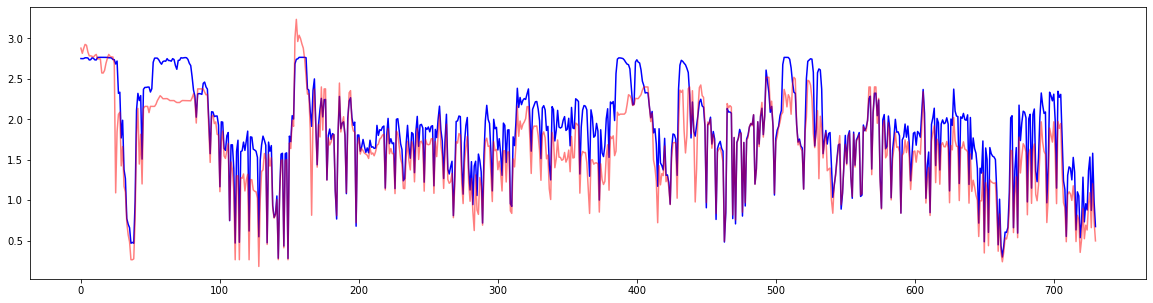

In [62]:
plt.figure(figsize=(20,5))
plt.plot(y_pred,color='blue')
plt.plot(y_valid,color='red',alpha=0.5)
plt.show()

# Trial 5: Lagged energy_generated

In [145]:
lag=7
DF=DF0.copy()
DF=DF.set_index('date')
DF2=DF[['energy_generated']]
DF2=DF2.shift(periods=lag)
DF2.rename({'energy_generated':'energy_generated_'+str(lag)},axis=1,inplace=True)
DF=DF.merge(DF2,on='date').reset_index()
DF['water_level_diff']=np.diff(DF.water_level,prepend=np.mean(DF.water_level))
DF=DF.dropna()
DF=DF[['date','water_level_diff','maximum_demand','energy_generated','energy_generated_'+str(lag)]]

In [205]:
date_train='2016-01-01'
date_validate='2018-01-01'

y_var='energy_generated'
X_train=np.array(DF.drop(['date',y_var],axis=1)[DF.date<date_train])
y_train=np.array(DF[y_var][DF.date<date_train])

X_valid=np.array(DF.drop(['date',y_var],axis=1)[(date_train<=DF.date) & (DF.date<date_validate)])
y_valid=np.array(DF[y_var][(date_train<=DF.date) & (DF.date<date_validate)])

X_test=np.array(DF.drop(['date',y_var],axis=1)[DF.date>=date_validate])
y_test=np.array(DF[y_var][DF.date>=date_validate])

In [206]:
X_train = np.reshape(X_train, (len(X_train), X_train.shape[1],1))
X_valid = np.reshape(X_valid, (len(X_valid), X_valid.shape[1],1))

In [207]:
print(X_train.shape)
y_train.shape

(5835, 3, 1)


(5835,)

In [208]:
model = models.Sequential()
model.add(layers.LSTM(5, activation='tanh',input_shape=X_train.shape[1:3]))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [209]:
model.compile(optimizer='rmsprop',loss='mse', metrics=['mse'])
history = model.fit(X_train,y_train,epochs = 200,validation_data=(X_valid,y_valid))

Epoch 1/200
183/183 [==============================] - 1s 5ms/step - loss: 2.5147 - mse: 2.5147 - val_loss: 1.2618 - val_mse: 1.2618
Epoch 2/200
183/183 [==============================] - 0s 2ms/step - loss: 0.6055 - mse: 0.6055 - val_loss: 0.2964 - val_mse: 0.2964
Epoch 3/200
183/183 [==============================] - 0s 2ms/step - loss: 0.3414 - mse: 0.3414 - val_loss: 0.2437 - val_mse: 0.2437
Epoch 4/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2986 - mse: 0.2986 - val_loss: 0.2274 - val_mse: 0.2274
Epoch 5/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2557 - mse: 0.2557 - val_loss: 0.2195 - val_mse: 0.2195
Epoch 6/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2407 - mse: 0.2407 - val_loss: 0.2227 - val_mse: 0.2227
Epoch 7/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2379 - mse: 0.2379 - val_loss: 0.2223 - val_mse: 0.2223
Epoch 8/200
183/183 [==============================] - 0s 2ms/step - 

Epoch 62/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2345 - mse: 0.2345 - val_loss: 0.2162 - val_mse: 0.2162
Epoch 63/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2347 - mse: 0.2347 - val_loss: 0.2177 - val_mse: 0.2177
Epoch 64/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2349 - mse: 0.2349 - val_loss: 0.2161 - val_mse: 0.2161
Epoch 65/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2350 - mse: 0.2350 - val_loss: 0.2164 - val_mse: 0.2164
Epoch 66/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2347 - mse: 0.2347 - val_loss: 0.2166 - val_mse: 0.2166
Epoch 67/200
183/183 [==============================] - 0s 1ms/step - loss: 0.2347 - mse: 0.2347 - val_loss: 0.2162 - val_mse: 0.2162
Epoch 68/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2347 - mse: 0.2347 - val_loss: 0.2161 - val_mse: 0.2161
Epoch 69/200
183/183 [==============================] - 0s 2ms

Epoch 123/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2341 - mse: 0.2341 - val_loss: 0.2194 - val_mse: 0.2194
Epoch 124/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2342 - mse: 0.2342 - val_loss: 0.2154 - val_mse: 0.2154
Epoch 125/200
183/183 [==============================] - 0s 1ms/step - loss: 0.2343 - mse: 0.2343 - val_loss: 0.2155 - val_mse: 0.2155
Epoch 126/200
183/183 [==============================] - 0s 1ms/step - loss: 0.2342 - mse: 0.2342 - val_loss: 0.2171 - val_mse: 0.2171
Epoch 127/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2342 - mse: 0.2342 - val_loss: 0.2156 - val_mse: 0.2156
Epoch 128/200
183/183 [==============================] - 0s 1ms/step - loss: 0.2340 - mse: 0.2340 - val_loss: 0.2157 - val_mse: 0.2157
Epoch 129/200
183/183 [==============================] - 0s 1ms/step - loss: 0.2341 - mse: 0.2341 - val_loss: 0.2149 - val_mse: 0.2149
Epoch 130/200
183/183 [==============================] 

In [218]:
#Finally check
y_pred=model.predict(X_valid)
y_valid=y_valid.reshape((len(y_valid),1))
np.mean((y_pred-y_valid)**2)

0.22081731729717552

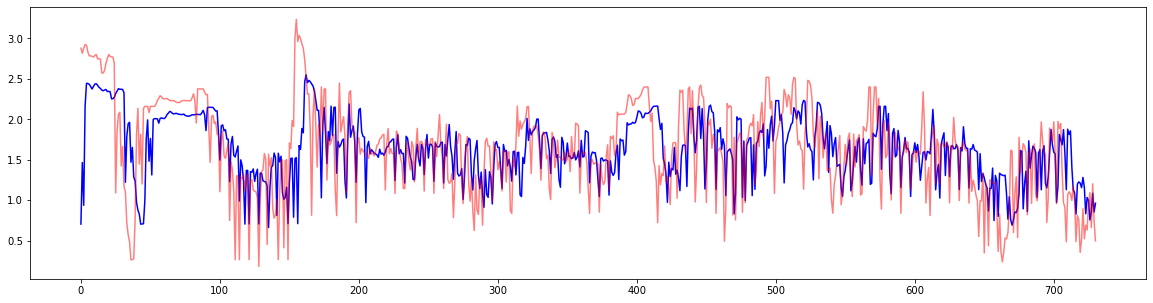

In [220]:
plt.figure(figsize=(20,5))
plt.plot(y_pred,color='blue')
plt.plot(y_valid,color='red',alpha=0.5)
plt.show()

In [221]:
lag=7
DF=DF0.copy()
DF=DF.set_index('date')
DF2=DF[['energy_generated','influent_flow']]
DF2=DF2.shift(periods=lag)
DF2.rename({'energy_generated':'energy_generated_'+str(lag),
            'influent_flow':'influent_flow_'+str(lag)},axis=1,inplace=True)
DF=DF.merge(DF2,on='date').reset_index()
DF['water_level_diff']=np.diff(DF.water_level,prepend=np.mean(DF.water_level))
DF=DF.dropna()
DF=DF[['date','water_level_diff','maximum_demand','influent_flow_'+str(lag),'energy_generated','energy_generated_'+str(lag)]]

In [222]:
date_train='2016-01-01'
date_validate='2018-01-01'

y_var='energy_generated'
X_train=np.array(DF.drop(['date',y_var],axis=1)[DF.date<date_train])
y_train=np.array(DF[y_var][DF.date<date_train])

X_valid=np.array(DF.drop(['date',y_var],axis=1)[(date_train<=DF.date) & (DF.date<date_validate)])
y_valid=np.array(DF[y_var][(date_train<=DF.date) & (DF.date<date_validate)])

X_test=np.array(DF.drop(['date',y_var],axis=1)[DF.date>=date_validate])
y_test=np.array(DF[y_var][DF.date>=date_validate])

In [223]:
X_train = np.reshape(X_train, (len(X_train), X_train.shape[1],1))
X_valid = np.reshape(X_valid, (len(X_valid), X_valid.shape[1],1))

In [224]:
print(X_train.shape)
y_train.shape

(5835, 4, 1)


(5835,)

In [225]:
model = models.Sequential()
model.add(layers.LSTM(5, activation='tanh',input_shape=X_train.shape[1:3]))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [226]:
model.compile(optimizer='rmsprop',loss='mse', metrics=['mse'])
history = model.fit(X_train,y_train,epochs = 200,validation_data=(X_valid,y_valid))

Epoch 1/200
183/183 [==============================] - 1s 4ms/step - loss: 1.9959 - mse: 1.9959 - val_loss: 0.7787 - val_mse: 0.7787
Epoch 2/200
183/183 [==============================] - 0s 2ms/step - loss: 0.4446 - mse: 0.4446 - val_loss: 0.2620 - val_mse: 0.2620
Epoch 3/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2835 - mse: 0.2835 - val_loss: 0.2362 - val_mse: 0.2362
Epoch 4/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2512 - mse: 0.2512 - val_loss: 0.2207 - val_mse: 0.2207
Epoch 5/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2307 - mse: 0.2307 - val_loss: 0.2068 - val_mse: 0.2068
Epoch 6/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2187 - mse: 0.2187 - val_loss: 0.2148 - val_mse: 0.2148
Epoch 7/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2122 - mse: 0.2122 - val_loss: 0.2128 - val_mse: 0.2128
Epoch 8/200
183/183 [==============================] - 0s 2ms/step - 

Epoch 123/200
183/183 [==============================] - 0s 2ms/step - loss: 0.1994 - mse: 0.1994 - val_loss: 0.2013 - val_mse: 0.2013
Epoch 124/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2004 - mse: 0.2004 - val_loss: 0.2036 - val_mse: 0.2036
Epoch 125/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2006 - mse: 0.2006 - val_loss: 0.2015 - val_mse: 0.2015
Epoch 126/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2001 - mse: 0.2001 - val_loss: 0.2034 - val_mse: 0.2034
Epoch 127/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2004 - mse: 0.2004 - val_loss: 0.1992 - val_mse: 0.1992
Epoch 128/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2001 - mse: 0.2001 - val_loss: 0.2087 - val_mse: 0.2087
Epoch 129/200
183/183 [==============================] - 0s 2ms/step - loss: 0.2001 - mse: 0.2001 - val_loss: 0.1990 - val_mse: 0.1990
Epoch 130/200
183/183 [==============================] 

In [218]:
#Finally check
y_pred=model.predict(X_valid)
y_valid=y_valid.reshape((len(y_valid),1))
np.mean((y_pred-y_valid)**2)

0.22081731729717552

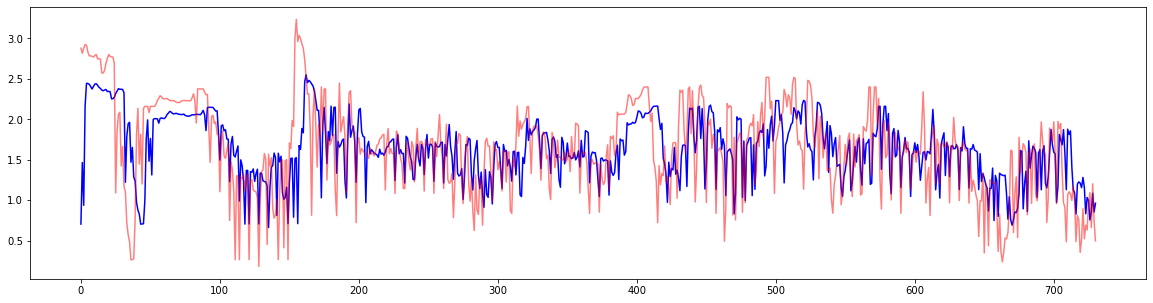

In [220]:
plt.figure(figsize=(20,5))
plt.plot(y_pred,color='blue')
plt.plot(y_valid,color='red',alpha=0.5)
plt.show()